In [1]:
!git clone https://github.com/fatimazahra1/Single-image-super-resolution-with-ResNet.git

fatal: destination path 'Single-image-super-resolution-with-ResNet' already exists and is not an empty directory.


In [2]:
cd Single-image-super-resolution-with-ResNet/

/content/Single-image-super-resolution-with-ResNet


In [3]:
import keras
from keras import layers
from keras.layers import Conv2D, Input , merge
from tqdm import tqdm
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Activation , Dense , Input , Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.optimizers import Adam
import skimage
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os, shutil
from skimage import io

%matplotlib inline

# Generator network

In [4]:
B=16

def conv_block(x, num_filters, filter_size,  act=True):
    x = Conv2D(num_filters, filter_size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x) if act else x
    x = layers.PReLU()(x)
    x = Conv2D(num_filters, filter_size, strides=(1,1), padding='same')(x) if act else x
    return BatchNormalization()(x) if act else x


def res_block(res_input, num_filters=64):
    x = conv_block(res_input, num_filters, (3,3) , act=True)
    return layers.add([x, res_input]) 


def up_block(x, num_filters, size):
    x = Conv2D(num_filters, size, strides=(1,1) , padding='same')(x)
    x = layers.UpSampling2D()(x)
    return layers.PReLU()(x)

def generator_net(inpt):
    x=conv_block(inpt, 64, (9,9), act=False)
    
    input_res_block = x
    
    for i in range(B):
        x = res_block(x)
        
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    x = layers.add([x, input_res_block])
    
    x = up_block(x, 256, (3,3))
    x = up_block(x, 256, (3,3))
    output=Conv2D(3, (1,1) , strides=(1,1), activation='tanh')(x)
  
    return output

input_generator = Input(shape=(64,64,3))
output_generator = generator_net(input_generator)

generator = Model(input_generator, output_generator)

In [5]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 64, 64, 64)   262144      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

In [6]:
import tensorflow as tf

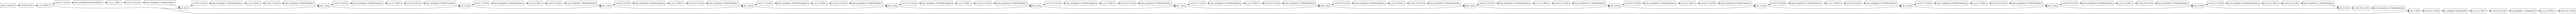

In [7]:

tf.keras.utils.plot_model(
    generator, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=96
)

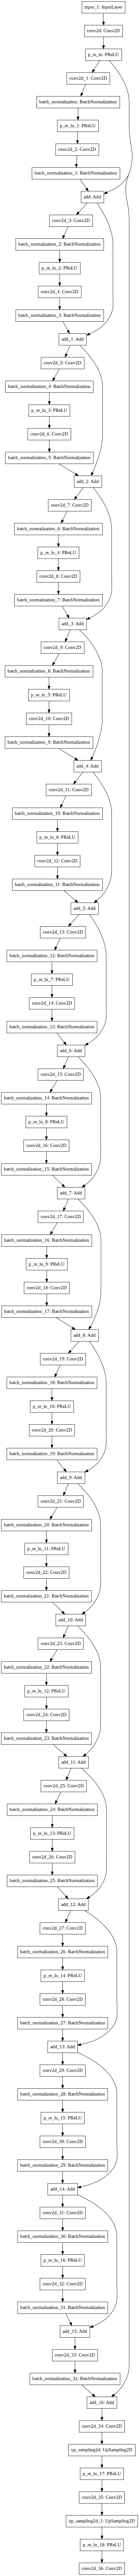

In [8]:
tf.keras.utils.plot_model(
    generator, to_file='model.png', show_shapes=False, show_layer_names=True, expand_nested=False, dpi=96
)

In [9]:
!git clone https://github.com/niazwazir/DATASETS.git

fatal: destination path 'DATASETS' already exists and is not an empty directory.


In [10]:
!pip uninstall scipy

Uninstalling scipy-1.1.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/scipy-1.1.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.1.0


In [11]:
!pip install scipy==1.1.0

  Using cached https://files.pythonhosted.org/packages/a8/0b/f163da98d3a01b3e0ef1cab8dd2123c34aee2bafbb1c5bffa354cc8a1730/scipy-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [12]:
from batch_generator import BatchGenerator
coco_dir = 'DATASETS/data/bsd200/'
batch_size = 4

batch_gen = BatchGenerator(directory=coco_dir,
                           batch_size=batch_size,
                           color_mode='rgb',
                           crop_mode='random_size',
                           downscale_factor=4,
                           shuffle=True,
                           target_size=(256,256),
                           seed=None)

num_samples = batch_gen.samples

Found 200 images


# Launch training

In [13]:
from keras.optimizers import SGD
from keras.optimizers import Adam
sgd = SGD(lr=0.0001)
adam = Adam(lr=1e-5, beta_1=0.9)

generator.compile(adam, loss='mse')


In [14]:
history = generator.fit_generator(batch_gen, 
                    epochs=1, #10
                    steps_per_epoch=num_samples//batch_size,
                    verbose=1)

generator.save('SRResNet_MSE_bis.h5', include_optimizer=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 18s 149ms/step - loss: 0.2417


In [15]:
def de_process_img_lr(img):
    return 255*img

def de_process_img_hr(img):
    return 127.5*(img + np.ones_like(img))

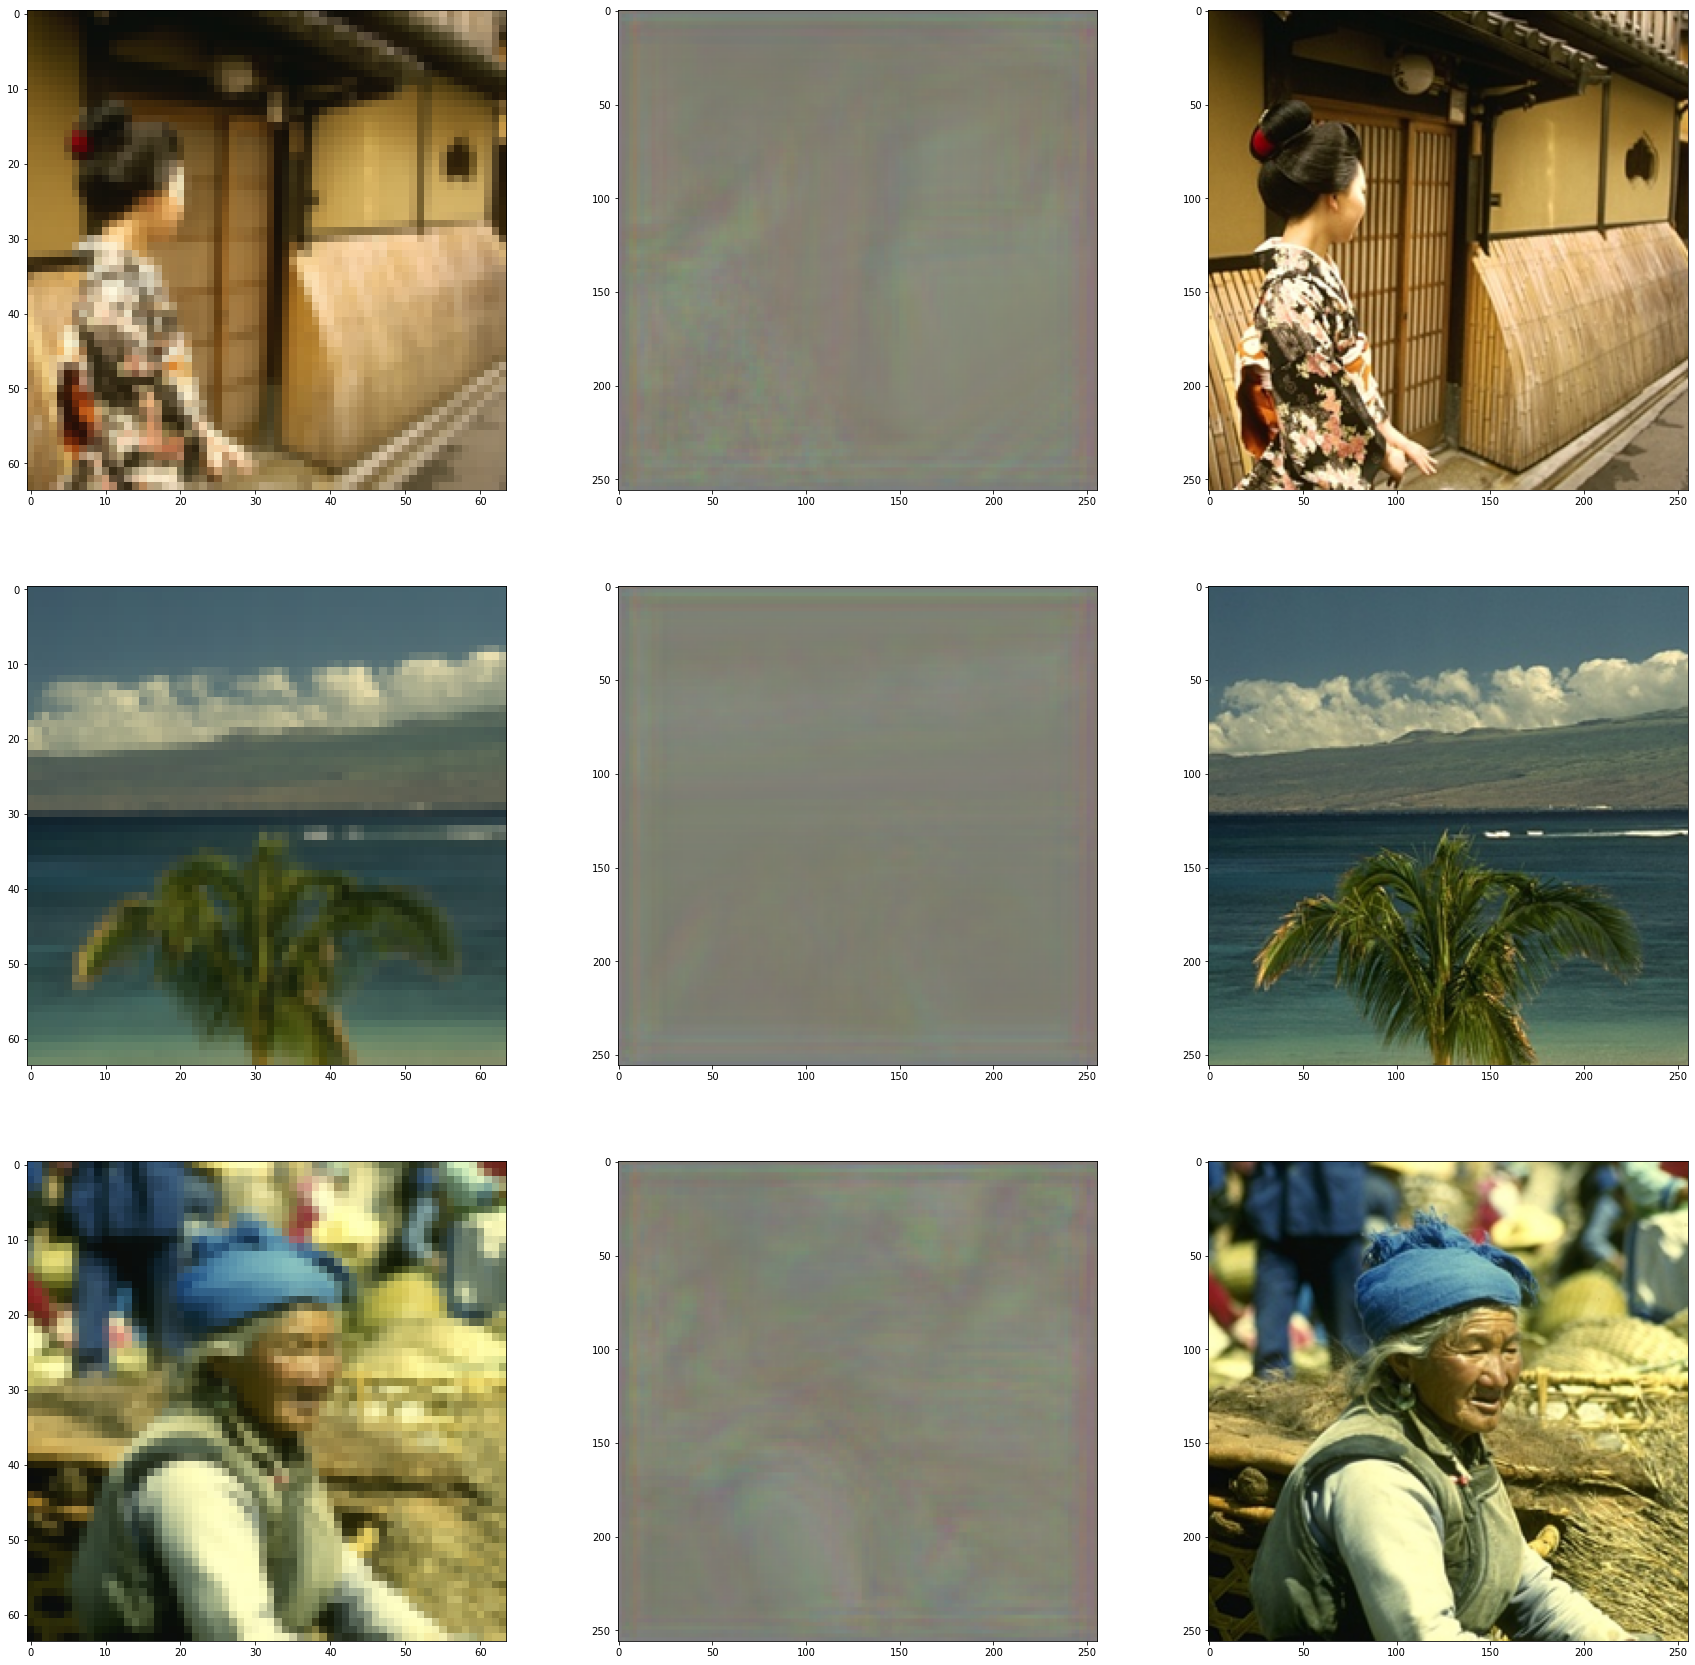

In [16]:
imgs_lr, imgs_hr = batch_gen.next()
imgs_sr = generator.predict(imgs_lr)

imgs_lr = de_process_img_lr(imgs_lr)
imgs_hr = de_process_img_hr(imgs_hr)
imgs_sr = de_process_img_hr(imgs_sr) 


fig, axes = plt.subplots(3, 3, figsize=(30, 30))
for i in range(3):
    
    axes[i, 0].imshow(imgs_lr[i].astype(np.uint8))
    axes[i, 1].imshow(imgs_sr[i].astype(np.uint8))
    axes[i, 2].imshow(imgs_hr[i].astype(np.uint8))

# Test set -  Set14

In [17]:
dir_set14 = 'DATASETS/data/set14/'
batch_size = 4

test_set14 = BatchGenerator(directory=dir_set14,
                           batch_size=batch_size,
                           color_mode='rgb',
                           crop_mode='random_size',
                           downscale_factor=4,
                           shuffle=True,
                           target_size=(256,256),
                           seed=None)
num_samples = test_set14.samples

Found 14 images


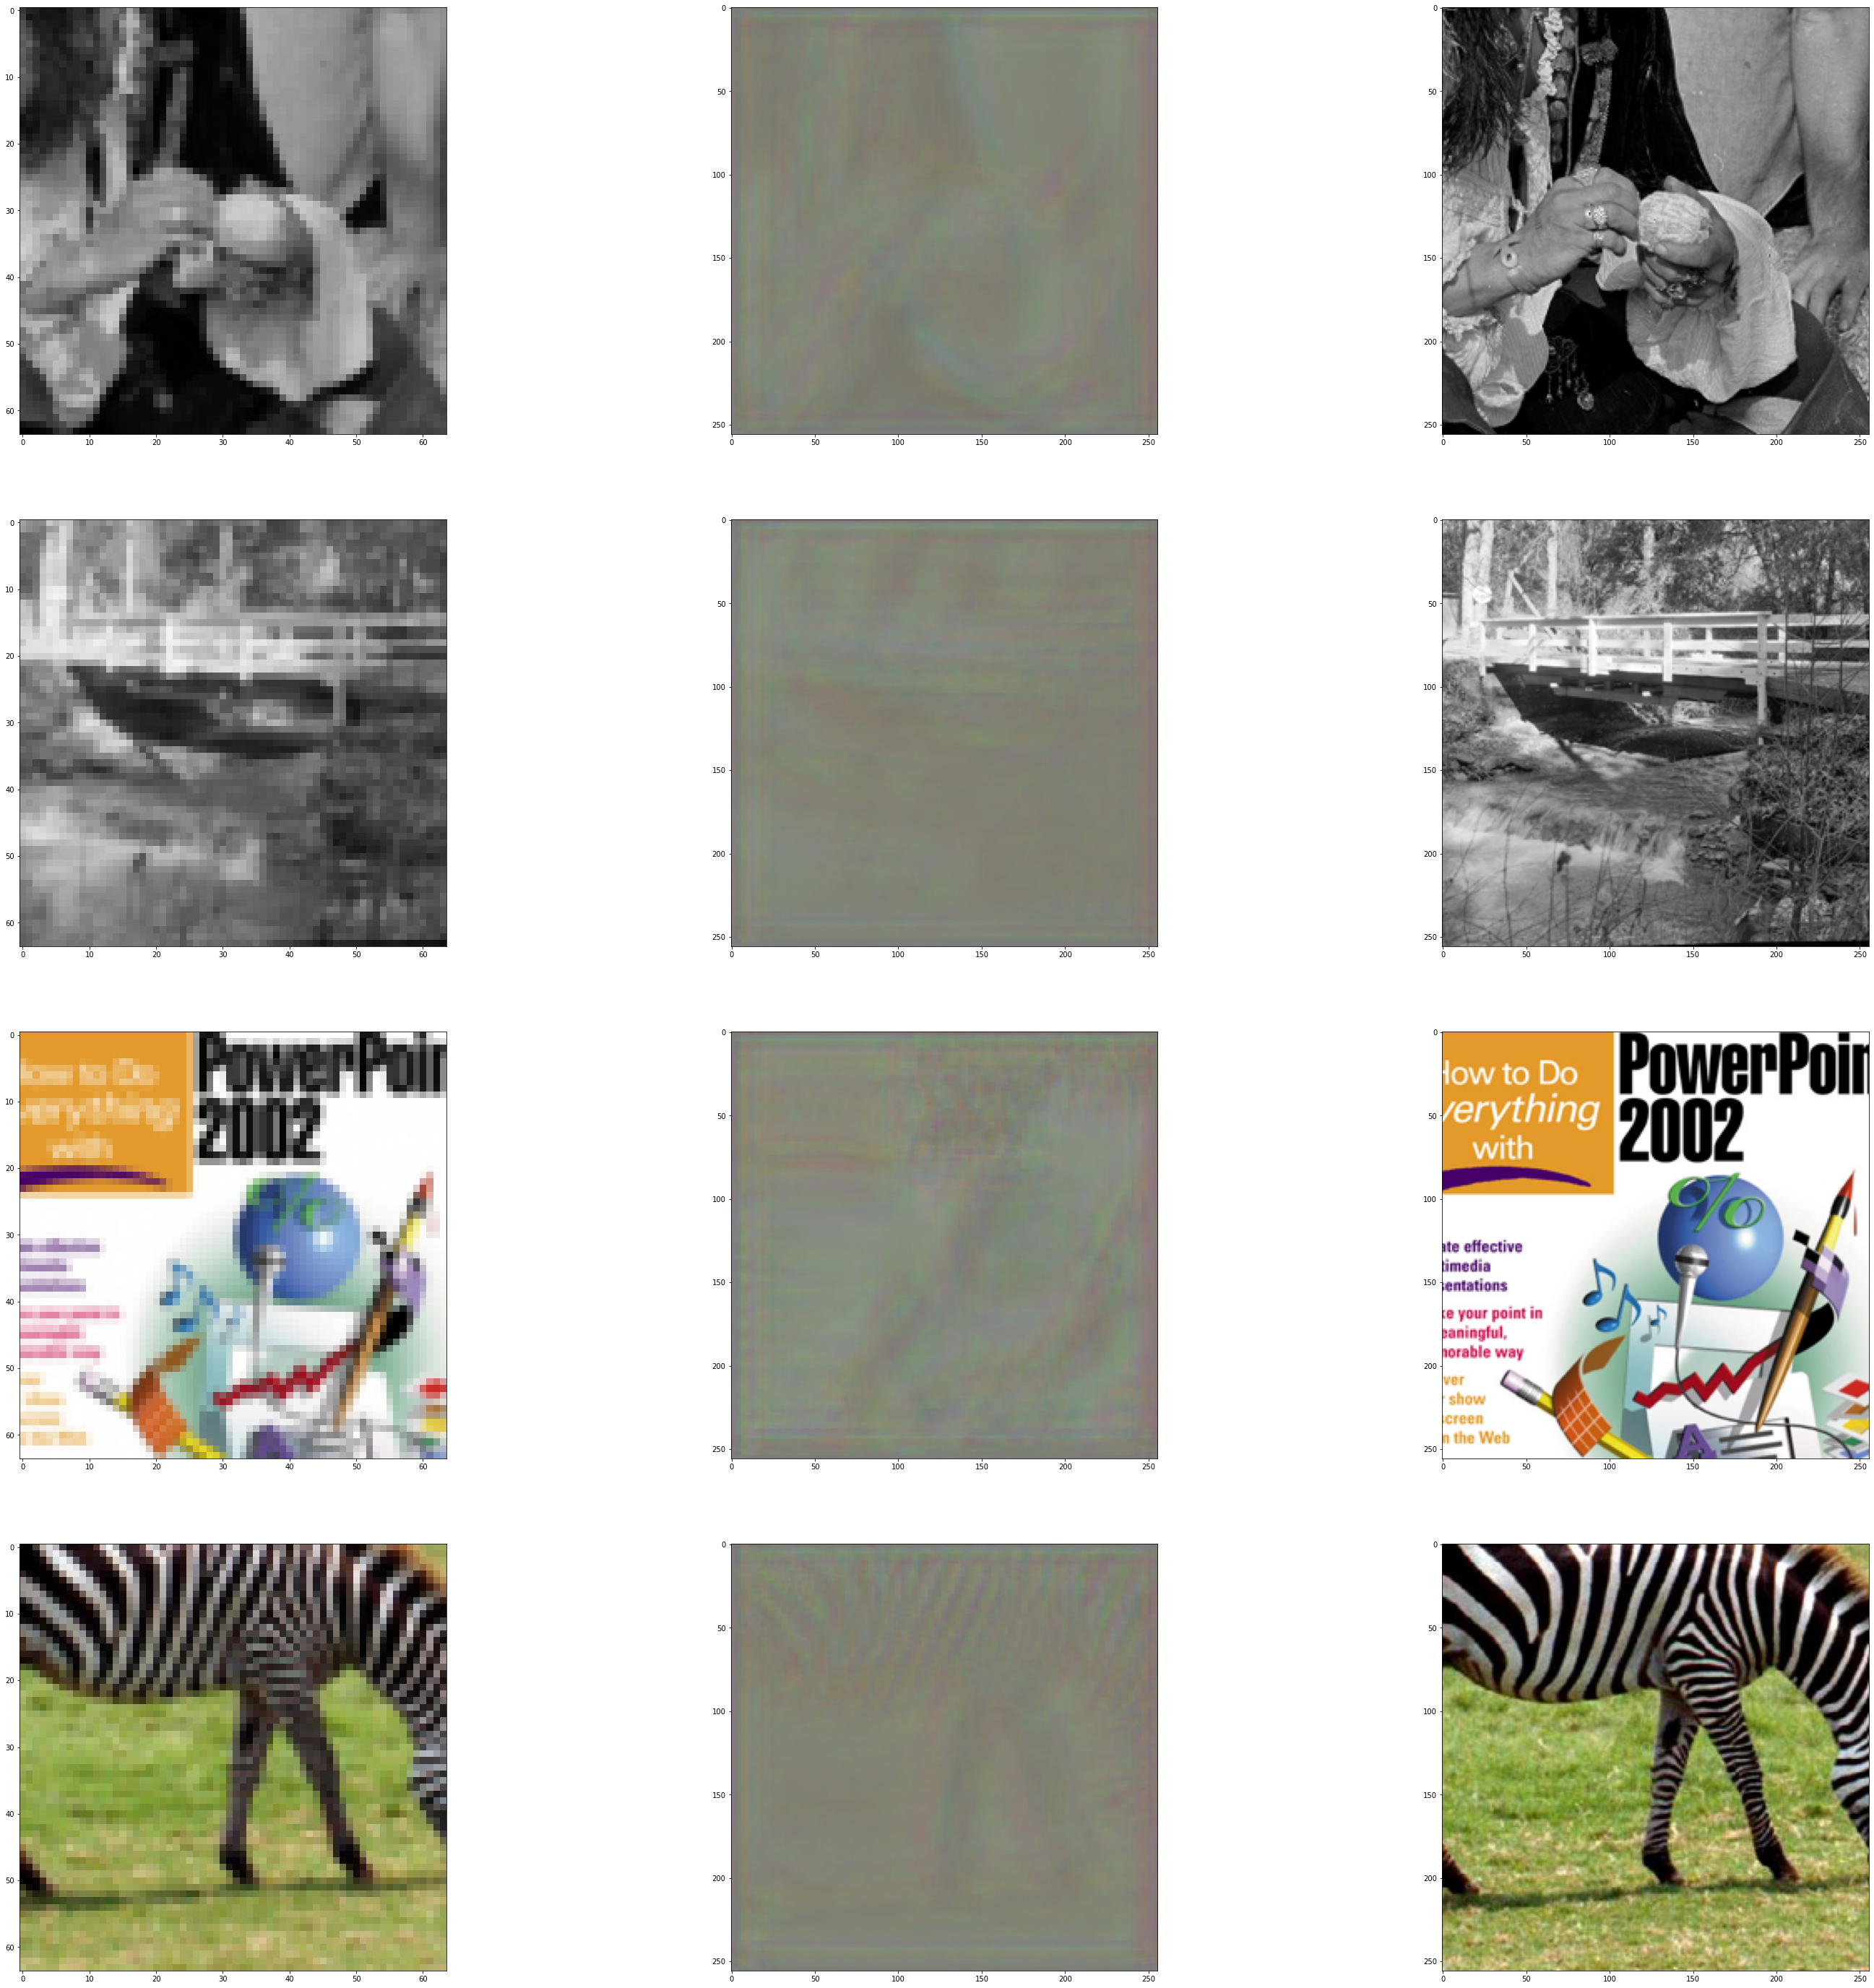

In [18]:
imgs_lr, imgs_hr = test_set14.next()
imgs_sr = generator.predict(imgs_lr)

imgs_lr = de_process_img_lr(imgs_lr)
imgs_hr = de_process_img_hr(imgs_hr)
imgs_sr = de_process_img_hr(imgs_sr)


fig, axes = plt.subplots(4, 3, figsize=(50, 50))
for i in range(4):
    
    axes[i, 0].imshow(imgs_lr[i].astype(np.uint8))
    axes[i, 1].imshow(imgs_sr[i].astype(np.uint8))
    axes[i, 2].imshow(imgs_hr[i].astype(np.uint8))